In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import v2
from utils.imageshow import imshow
from utils import tt_pytorch_website
import matplotlib.pyplot as plt
import json

import ssl

BATCH_SIZE = 4
EPOCHS = 5
MODEL_PATH = 'model/cifar10_pytorch.pth'
DEVICE = (
  "cuda"
  if torch.cuda.is_available()
  else "mps"
  if torch.backends.mps.is_available()
  else "cpu"
)

In [2]:
transform = v2.Compose([
  # v2.Resize(size=(IMAGE_HEIGHT, IMAGE_WIDTH)) CIFAR10 dataset is already resized to 32x32
  v2.ToImage(),
  v2.ToDtype(torch.float32, scale=True),
  v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
ssl._create_default_https_context = ssl._create_unverified_context

#CIFAR10 of 32x32x3 image
trainset = CIFAR10('data', train=True, download=True, transform=transform)
testset = CIFAR10('data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [5]:
train_dataloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_dataloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

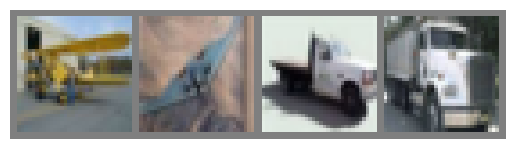

airplane airplane truck truck


In [6]:
data_iterator = iter(train_dataloader)
X, y = next(data_iterator)

imshow(torchvision.utils.make_grid(X))
print(' '.join(f'{classes[y[j]]}' for j in range(BATCH_SIZE)))

In [7]:
class CIFAR_model(nn.Module):
  def __init__(self):
    super(CIFAR_model, self).__init__()
    # Original shape: 32x32x3
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5,5))
    self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5))
    self.fc1 = nn.Linear(in_features=5*5*16, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=84)
    self.fc3 = nn.Linear(in_features=84, out_features=10)
  
  def forward(self, x):
    # Use functional API for stateless objects. Unnessecary to use nn.relu, but required if defined in __init__
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, start_dim=1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
model = CIFAR_model().to(DEVICE)

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [9]:
loss_list, accuracy_list = tt_pytorch_website.train(model, train_dataloader, loss_fn, optimizer, EPOCHS, DEVICE)

[1,  4000] -------- Mini-batch Loss 4.1221
[1,  8000] -------- Mini-batch Loss 3.2668
[1, 12000] -------- Mini-batch Loss 2.9418
[2,  4000] -------- Mini-batch Loss 2.7156
[2,  8000] -------- Mini-batch Loss 2.5965
[2, 12000] -------- Mini-batch Loss 2.5378
[3,  4000] -------- Mini-batch Loss 2.3834
[3,  8000] -------- Mini-batch Loss 2.3503
[3, 12000] -------- Mini-batch Loss 2.3273
[4,  4000] -------- Mini-batch Loss 2.1236
[4,  8000] -------- Mini-batch Loss 2.1819
[4, 12000] -------- Mini-batch Loss 2.2066
[5,  4000] -------- Mini-batch Loss 2.0140
[5,  8000] -------- Mini-batch Loss 2.0368
[5, 12000] -------- Mini-batch Loss 2.0537
Training Finished


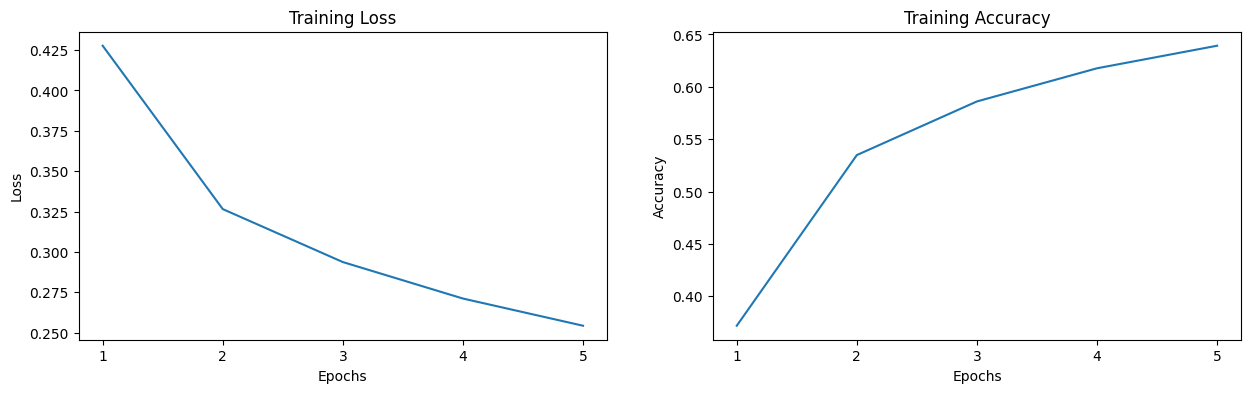

In [10]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
ax[0].set_title("Training Loss")
ax[0].plot(loss_list)
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_xticks(range(0, EPOCHS), range(1, EPOCHS+1))

ax[1].set_title("Training Accuracy")
ax[1].plot(accuracy_list)
ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_xticks(range(0, EPOCHS), range(1, EPOCHS+1))
plt.show()

In [11]:
#Instead of saving the model directly, it is recommended by Pytorch to save only the state dict (for compatibility reasons)
#After saving, you can load it using load_state_dict
torch.save(model.state_dict(), MODEL_PATH)

In [12]:
with open("listHistory/lossHistory", "w") as fp:
  json.dump(loss_list, fp)

with open("listHistory/accuracyHistory", "w") as fp:
  json.dump(accuracy_list, fp)

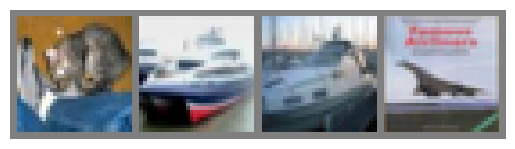

Ground Truth Label: cat ship ship airplane


In [13]:
data_iterator = iter(test_dataloader)
X, y = next(data_iterator)

imshow(torchvision.utils.make_grid(X))
print("Ground Truth Label:", ' '.join(f'{classes[y[j]]}' for j in range(BATCH_SIZE)))

## Load saved models and loss/accuracy history

In [14]:
model = CIFAR_model()
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [15]:
with open("listHistory/lossHistory", "r") as fp:
  loss_list = json.load(fp)

with open("listHistory/accuracyHistory", "r") as fp:
  accuracy_list = json.load(fp)

print(loss_list)
print(accuracy_list)

[0.42771669790536165, 0.32652497887939214, 0.29371742779642346, 0.27112468056831507, 0.25429053381203676]
[0.37186, 0.53484, 0.58606, 0.61772, 0.63926]


In [16]:
tt_pytorch_website.test(model, test_dataloader, DEVICE)

Test Accuracy of size 10000: 61.85 %


In [17]:
# Parts from Pytorch Website, removed redundancy, additional graphing and json read/write functionality for loss/accuracy history